# 순환 신경망(RNN)

- 피드포워드(feed forward) : 흐름이 단방향인 신경망
    - 구성이 단순하여 구조를 이해하기 쉬움 -> 많은 문제에 응용 가능
    - 시계열 데이터를 잘 다루지 못함
- 순환신경망(RNN)
    - 맥락의 정보를 기억하는 매커니즘을 갖추고 있음

## 확률과 언어 모델

### Embedding model(CBOW)
- Embedding model의 사후확률
    - 맥락이 있을 때, 해당 단어의 출현 확률
    - 수식 : $P(w_{t}|w_{t-2}, w_{t-1})$
- 손실함수 : $L = -logP(w_{t}|w_{t-2}, w_{t-1})$
- 이러한 과정을 통해 모델을 학습시키고 결과를 얻음
- Embedding model의 산출물
    - 단어의 분산 표현
    - 사후 확률

### 언어모델
- 단어 나열에 확률을 부여. 특정한 단어의 시퀀스에 대해서, 그 시퀀스가 일어날 가능성이 어느 정도인지(얼마나 자연스러운 단어 순서인지)를 확률로 평가
- 예) 기계번역, 음성 인식, 새로운 문장을 생성
- 언어모델의 사후확률
    - $w_{1}$, ..., $w_{m}$이라는 m개의 단어로 된 문장이 순서대로 출현할 확률
    - $P(w_{1},...,w_{m}) = P(w_{m}|w_{1},...,w_{m-1})P(w_{m-1}|w_{1},...,w_{m-2})...P(w_{2}|w_{1})P(w_{1})$ = $\Pi_{t=1}^{m}P(w_{t}|w_{1},...,w_{t-1})$

### CBOW 모델을 언어모델로?
- 수정할 부분
    - 1. 맥락 전체를 고려하기 위해 맥락의 크기를 크게 키워야함.
    - 2. 맥락의 순서를 고려하기 위해 단어 벡터의 '합'을 은닉층에 오게 하는 것이 아닌 맥락의 단어 벡터를 은닉층에서 **연결**하는 방식을 취함
    - 하지만, 1을 하게 된 이후 2를 하게 되면 가중치 매개변수가 매우 커지는 문제점이 발생 -> 새로운 언어모델이 필요

## RNN이란
- RNN(순환신경망)의 특징
    - 순환하는 경로(닫힌 경로)가 존재 -> 최신 데이터로 갱신될 수 있음
    - 시각 t-1에 대한 $h_{t}$ => 시각 t의 hidden layer & 시각 t-1의 output
- 시각 t의 은닉 상태($h_{t}$) : $h_{t} = tanh(h_{t-1}W_{h}+x_{t}W_{x}+b)$
    - 배치 사이즈 : N, output : H
    - $W_{t}$ : 입력 x를 출력 h로 변환하기 위한 가중치(NxH)
    - $W_{h}$ : RNN 출력을 다음 시각의 출력으로 변환하기 위한 가중치(HxH)
    - b : 편향
    - $x_{t}$ : 시각 t의 입력(NxD)
- RNN의 가중치 공유($W_{t}, W_{h}$는 모든 layer에서 동일)
    - 학습할 파라미터가 줄어듦
    - 데이터별 시간 단위에 유연(어디에 넣어도 같은 결과가 나오기 때문)

### BPTT
- BPTT(backpropagation through time) : 시간 방향으로 펼친 신경망의 오차역전파법
- 긴 시계열 데이터에 오차역전파법을 할 때의 문제
    - 시계열 데이터의 시간 크기가 커지는 것에 비례하여 BPTT가 소비하는 컴퓨팅자원도 증가(RNN 계층의 중간 데이터를 메모리에 유지해두어야 하기 때문)
    - 계산량 증가
    - gradient 소멸 문제

### Truncated BPTT
- 너무 길어진 신경망은 적당한 지점에서 잘라내어 작은 신경망 여러 개로 만들어 오차역전파법을 수행하는 방법
- **순전파의 연결은 반드시 그대로 유지한채로 역전파의 연결만 적당한 길이로 잘라내어 학습**
- 데이터 제공에서 유의할 점
    - 데이터를 **순서대로 제공**
    - 데이터를 미니배치로 제공하는 경우 **시작 위치를 옮기기**
        - 예를들어 길이가 1,000인 시계열을 미니배치의 수를 두 개로 구성해 학습한다면, 첫 번째 미니배치는 처음부터 순서대로 데이터를 제공, 두 번째 미니배치 때에는 500번째의 데이터를 시작 위치로 정하고, 그 위치부터 다시 순서대로 데이터를 제공(시작 위치를 500만큼 옮겨줌)

## RNN 구현
- input : $xs(x_{0}, x_{1}, x_{2}, ... , x_{T-1})$
- hidden layer(Time RNN) : T개 단계분의 작업을 한꺼번에 처리. 한 단계의 작업을 수행하는 RNN계층으로 이루어져 있음
- output : $hs(h_{0}, h_{1}, h_{2}, ... , h_{T-1})$

### RNN 계층 구현

In [3]:
import numpy as np

class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx, np.zeros_like(Wh), np.zeros_like(b))]
        
        # 역전파 계산 시 사용하는 중간 데이터
        self.cache = None
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
        
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1-h_next**2)
        db = np.sum(dt.sum, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

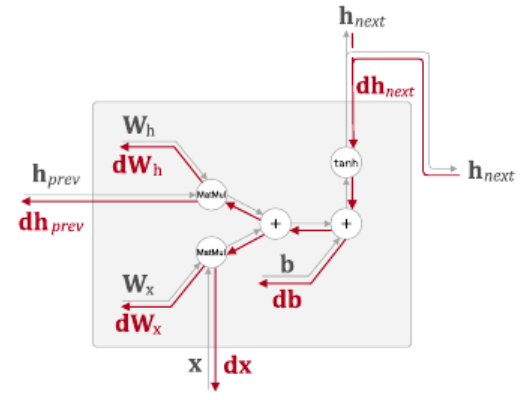

### Time RNN 계층 구현
- 각 RNN 계층의 은닉상태(h)를 인스턴트 변수로 유지하여 '인계'받는 작업을 수행

In [8]:
import numpy as np

class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        
        # RNN계층을 리스트로 저장할 변수
        self.layers = None
        
        self.h , self.dh = None, None
        # 이전 상태의 은닉상태를 유지할지를 지정(Truncated BPTT => False)
        self.stateful = stateful
        
    def self_state(self,h):
        self.h = h
        
    def reset_state(self):
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N,T,H), dtype="f")
        
        # 첫번째 RNN 계층이거나 이전 은닉상태를 받지 않는다면 0으로 초기화
        if not self.stateful or self.h is None:
            self.h = np.zeros((N,H), dtype = "f")

        for t in range(T):
            
            # self.params에 저장되어 있는 것을 인자로 넣어줌
            layer = RNN(*self.params) 
            self.h = layer.forward(xs[:,t,:], self.h)
            hs[:,t,:] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N,T,D), dtype="f")
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t] # RNN layer 추가
            
            # 두 갈래에서 dh(t)를 받기 때문에 합
            dx, dh = layer.backward(dhs[:,t,:]+dh)
            dxs[:,t,:] = dx
            
            # 같은 가중치를 공유하기 때문에 모두 더함
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        # 더한 것을 인스턴스 변수로 저장
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

- self.h 에는 마지막 RNN layer의 h가 저장. 만약 stateful이 False라면 0으로 초기화, True라면 마지막 h을 이용

## 시계열 데이터 처리 계층 구현
- RNNLM(RNN Language Model) : RNN을 사용한 언어 모델
    - 지금까지 입력된 단어를 '기억'하고, 그것을 바탕으로 다음에 출현할 단어를 예측.
    - RNN layer가 과거에서 현재로 데이터를 계속 흘려보내줌으로써 과거의 정보를 인코딩해 저장할 수 있음

### RNNLM 계층
1. **Embedding layer** : 단어 ID를 단어의 분산 표현(단어 벡터)로 변환
2. **RNN layer** : 은닉 상태를 다음 층(Affine)계층으로 출력함과 동시에, 다음 시각의 RNN 계층으로(오른쪽 RNN)으로 출력.
    - 다음 시각의 RNN 계층으로 출력한 덕분에, RNN은 과거의 정보를 응집된 은닉 상태 벡터로 저장해두고 이와 같은 정보가 반영됨
3. **Affine layer**
4. **Softmax layer**

*Time XX계층*
- T개분의 시계열 데이터를 한꺼번에 처리하는 계층
- time affine, time embedding, time RNN

In [ ]:
import sys
sys.path.append("..")
import numpy as np
from function.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화 -> Xavier 초깃값 이용(input layer만을 사용한 간소화된 구현)
        # 언어 모델에서는 균일분포를 사용하는 사례도 많이 있음
        embed_W = (rn(V, D) / 100).astype("f")
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype("f")
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype("f")
        rnn_b = np.zeros(H).astype("f")
        affine_W = (rn(H, V) / np.sqrt(H)).astype("f")
        affine_b = np.qeros(V).astype("f")
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모음
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs,ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    # 신경망의 상태를 초기화
    def reset_state(self):
        self.rnn_layer.reset_state()

## 언어 모델의 평가
- **퍼블렉서티(perplexity, 혼란도)** : 언어 모델은 주어진 과거 단어(정보)로부터 다음에 출현할 단어의 확률분포를 출력하는 특성에 맞춘 언어 모델 예측 성능 평가 척도
    - 데이터가 하나라면 '확률의 역수'
    - 직관적으로, 다음에 취할 수 있는 선택사항의 수(다음에 출현할 수 있는 단어의 후보 수, 분기수)
    - 작을수록 좋음


$L = -\frac{1}{N}\sum_{n}\sum_{k}t_{nk}logy_{nk}$  
    - cross-entropy-error와 완전히 같은 식
$perplexity = e^{L}$

## RNNLM의 학습 코드

In [ ]:
import sys
sys.path.append("..")
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from sinple_rnnlm import SimpleRnnlm

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 말뭉치 중 1000의 단어만 사용)
corpus, word_to_id, id_to_word = ptb.load_data("train")
corpus_size = 1000 # 일정 크기로 정해줌
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus)+1)

xs = corpus[:-1] #입력
ts = corpus[1:] #출력(정답 레이블)
data_size = len(xs) # xs와 ts의 데이터 크기는 같기 때문에 xs로만 길이 구함
print("말뭉치 크기 : %d, 어휘 수 :%d"%(corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 각 미니배치에서 샘플을 읽기 시작 위치를 계산
# 각 xs와 ts는 corpus size에서 1을 뺀 만큼이 길이기 때문에 1을 빼줌
jump = (corpus_size - 1)//batch_size
offsets = [i * jump for i in range(batch_size)]

# 에포크 마다
for epoch in range(max_epoch):
    
    # 한 에포크 안에서 반복
    for iter in range(max_iters):
        batch_x = np.empty((batch_size, time_size), dtype="i")
        batch_t = np.empty((batch_size, time_size), dtype="i")
        
        # 배치 데이터 구하는 것 시작
        for t in range(time_size):
            # time마다의 시작위치
            for i, offset in enumerate(offsets):
                # time_idx가 계속 더해지기 때문에
                # 말뭉치의 크기를 나눈 나머지를 인덱스로 사용
                batch_x[i, t] = xs[(offset+time_idx)%data_size]
                batch_t[i, t] = ts[(offset+time_idx)%data_size]
            
            # time_idx를 0으로 초기화하지 않기 때문에 말뭉치의 크기를 넘어서는 경우가 발생
            # 이 때문에 배치가 랜덤으로 만들어지는 효과도 있는 것으로 보임
            # RNN의 가중치는 모든 time 층에서 같기 때문에 가능
            time_idx += 1
        
        # 배치마다 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t) # forward시 
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count) # 퍼플렉서티는 cross-entropy-error에 지수승
    print("에폭 %d, 퍼플렉서티 %2.f"
         %(epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

## 정리 
- RNN은 데이터를 순환시킴으로써 과거에서 현재, 그리고 미래로 데이터를 계속해서 흘려보냄. 이를 위해 RNN 계층 내부에는 '은닉 상태'를 기억하는 능력이 추가됨
- RNN을 이용한 언어 모델은 단어 시퀀스에 확률을 부여하며, 특히 조건부 언어 모델은 지금까지의 단어 시퀀스로부터 다음에 출현할 단어의 확률을 계산.